In [1]:
from __future__ import print_function
from __future__ import division
import numpy as np
import scipy.stats as stats
import scipy.special as special
import pandas as pd
import chaospy as cp

%matplotlib inline
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns

sns.set_style("ticks")#'whitegrid')#
#sns.set_context("talk")
sns.set_style({'axes.linewidth':0.5,
               'xtick.direction': u'in',
               'xtick.major.size': 1.,
               'xtick.minor.size': 0.5,
               'ytick.direction': u'in',               
               'ytick.major.size': 1.,
               'ytick.minor.size': 0.5})  


:0: FutureWarning: IPython widgets are experimental and may change in the future.


# 1) Single uncertain variable

Model:

$ u = I\,e^{-a\,x} $ 

In [2]:
def u(x,a,I):
    return I*np.exp(-a*x)

x = np.linspace(0,10,101)
I = 1.

with uncertain inputs: $a$

In [3]:
#cp.Uniform(lo=0, up=0.1)
#dist_a = cp.Normal(mu=0.08,sigma=0.02)
dist_a = cp.Weibull(shape=2., scale=0.1, shift=0)

### a) MC propagation

A full Monte-Carlo simulation of the inputs is done ussing a reduced variance sampling method.

"K"     Korobov             
"R"     (Pseudo-)Random     
"L"     Latin hypercube     
"S"     Sobol               
"H"     Halton              
"M"     Hammersley          

In [4]:
sample_a = dist_a.sample(size=1000,rule='L')

The input sample is propagated through the model

In [5]:
sample_u = np.array([u(x,a,I) for a in sample_a])

In [6]:
E_u = np.mean(sample_u,axis=0)
Std_u = np.std(sample_u,axis=0)
Q05_u = np.percentile(sample_u,5,axis=0)
Q95_u = np.percentile(sample_u,95,axis=0)

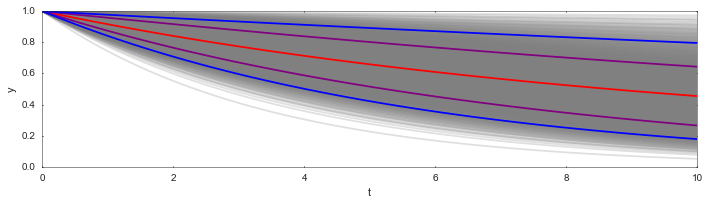

In [7]:
fig = plt.figure(figsize=[10,3])
ax = fig.add_subplot(111)
ax.plot(x,sample_u.T,'grey',alpha=0.25)
ax.plot(x,E_u,'r')
ax.plot(x,E_u+Std_u,'purple')
ax.plot(x,E_u-Std_u,'purple')
ax.plot(x,Q05_u,'blue')
ax.plot(x,Q95_u,'blue')
ax.set_xlabel('t')
ax.set_ylabel('y')

fig.tight_layout()
fig.savefig('Figures/1_Weibull_MC.pdf')
print()

### b) PCE with Pseudo-spectral collocation

In [8]:
M = 3    # Order of the polynomial
N = M + 1 # Number of terms, evaluations per dimension

Generation of the polynomial basis using the Stiltjes algorithm (three term recursive expression).

In [9]:
P = cp.orth_ttr(M, dist_a)

The polynomials are not normalized (this is not required)

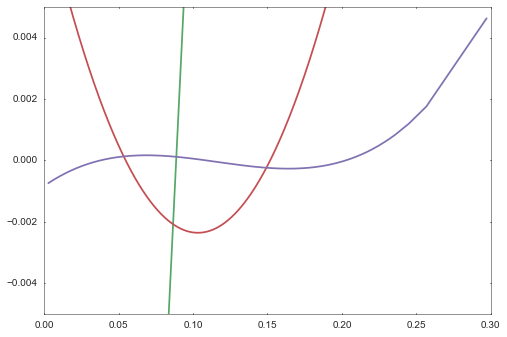

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
for p in P:
    ax.plot(np.sort(sample_a),p(np.sort(sample_a)))
#ax.set_xlim([0,2])
ax.set_ylim([-0.005,0.005])
print()

Pseudo-spectral collocation used based on Gaussian quadrature. Gaussian quadrature is a familly of quadratures that gives the nodes and weights of the integration scheme corresponding to the weighting pdf. 

In [11]:
nodes, weights = cp.generate_quadrature(M,dist_a,rule='G')
print('nodes: ', nodes)
sample_u_pc = np.array([u(x,*node,I=I) for node in nodes.T])

nodes:  [[ 0.02800995  0.08320771  0.15563899  0.24632849]]


The PCE is computed by projecting the model evaluations in the polynomial basis. 

This requires: 
* P: Polynomial basis
* nodes: location of model evaluations
* weights: weight corresponding to each node in the Gauss quadrature rule
* sample_u_pc: model evaluated at the nodes

In [12]:
u_hat_pc = cp.fit_quadrature(P,nodes,weights,sample_u_pc)

In [13]:
mean_u_pc, var_u_pc = cp.E(u_hat_pc, dist_a), cp.Var(u_hat_pc, dist_a),

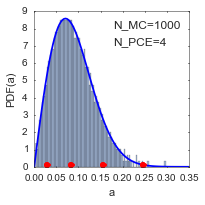

In [14]:
fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)

ax.hist(x=sample_a,bins=100,normed=True, alpha=0.5)
ax.plot(np.linspace(0,0.35,100), dist_a.pdf(np.linspace(0,0.35,100)), color='b')
ax.plot(nodes,0.1,'or')
ax.set_xlabel('a')
ax.set_ylabel('PDF(a)')
ax.set_xticks(np.linspace(0,0.35,8))
ax.text(0.18,8.,'N_MC=1000')
ax.text(0.18,7,'N_PCE=4')
fig.tight_layout()
fig.savefig('Figures/1_Weibull_MC_sample.pdf')
print()

A full MC can be performed on the PCE surrogate

In [15]:
sample_u_hat = np.array([u_hat_pc(in_vars) for in_vars in sample_a.T ])

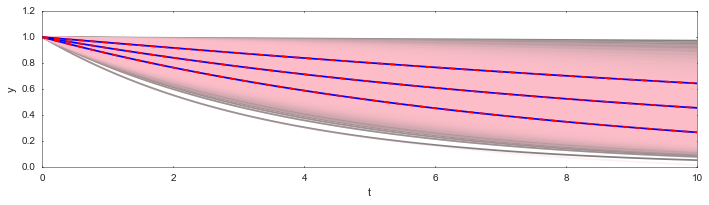

In [16]:
fig = plt.figure(figsize=[10,3])
ax = fig.add_subplot(111)
ax.plot(x,sample_u.T,'grey')
ax.plot(x,sample_u_hat.T,'pink',alpha=0.25)

ax.plot(x,E_u,'blue')
ax.plot(x,E_u+Std_u,'blue')
ax.plot(x,E_u-Std_u,'blue')

ax.plot(x,mean_u_pc,'--r')
ax.plot(x,mean_u_pc+var_u_pc**.5,'--r')
ax.plot(x,mean_u_pc-var_u_pc**.5,'--r')

ax.set_xlabel('t')
ax.set_ylabel('y')

fig.tight_layout()
fig.savefig('Figures/1_Weibull_top.pdf')
print()

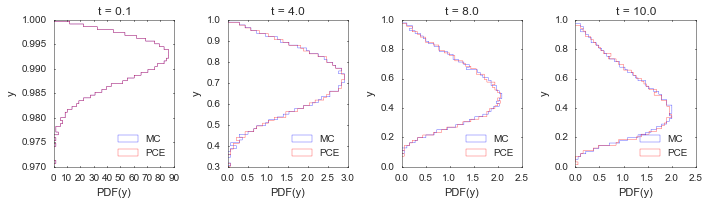

In [17]:
x_ref = 9.9

fig = plt.figure(figsize=[10,3])

for i,x_ref in enumerate([.1, 4., 8., 10.]):
    ax = fig.add_subplot(1,4,i+1)
    ax.hist(sample_u[:,np.where(x==x_ref)[0]],
             bins=50,#np.linspace(-0.2,.2,50),
             histtype='step',
             color='blue',
             normed=True,
             cumulative=False,
             label='MC',
             orientation=u'horizontal',
            )

    ax.hist(sample_u_hat[:,np.where(x==x_ref)[0]],
             bins=50,#np.linspace(-0.2,.2,50),
             histtype='step',
             color='red',
             normed=True,
             cumulative=False,
             label='PCE',
             orientation=u'horizontal',
            )

    ax.set_ylabel('y')
    ax.set_xlabel('PDF(y)')
    ax.set_title('t = '+str(x_ref))
    ax.legend(loc='lower right')

fig.tight_layout()    
fig.savefig('Figures/1_Weibull_bot.pdf')    
print()

### Convergence

```python
sample_inputs = dist_a.sample(size=int(1e6),rule='H')
sample_u = np.array([u(x,a,I) for a in sample_inputs.T])

E_u = np.mean(sample_u,axis=0)
Std_u = np.std(sample_u,axis=0)
#```

In [18]:
#```python
M = 10    # Order of the polynomial
P = cp.orth_ttr(M, dist_a)
nodes, weights = cp.generate_quadrature(M, dist_a, rule='G')
samples_u_pc = [u(x,a,I) for a in nodes.T]
u_hat = cp.fit_quadrature(P, nodes, weights, samples_u_pc)
E_u, Std_u = cp.E(u_hat, dist_a), cp.Std(u_hat, dist_a)
#```

In [19]:
def PCE(M):
    # M: Order of the polynomial

    P = cp.orth_ttr(M, dist_a)
    nodes, weights = cp.generate_quadrature(M, dist_a, rule='G')
    Npc = len(P)
    print('No. model evaluations:', len(P))
    
    samples_u_pc = [u(x,a,I) for a in nodes.T]
    u_hat = cp.fit_quadrature(P, nodes, weights, samples_u_pc)

    mean_u_pc, std_u_pc = cp.E(u_hat, dist_a), cp.Std(u_hat, dist_a)
    
    
    Error_E = np.trapz(np.abs(E_u - mean_u_pc)/E_u,x)/10.
    Error_Std = np.trapz(np.abs(std_u_pc[1:]**2./Std_u[1:]**2. - 1.),x[1:])/10.  
    
    return Npc,Error_E, Error_Std

In [20]:
order = range(2,8)
Npc     = np.zeros(len(order))
Error_E = np.zeros(len(order))
Error_Std = np.zeros(len(order))

for i,M in enumerate(order):
    Npc[i],Error_E[i], Error_Std[i] = PCE(M)

No. model evaluations: 3
No. model evaluations: 4
No. model evaluations: 5
No. model evaluations: 6
No. model evaluations: 7
No. model evaluations: 8


In [21]:
def MC(Nmc):
    sample_inputs = dist_a.sample(size=Nmc,rule='H')
    sample_u = np.array([u(x,a,I) for a in sample_inputs.T])

    E_u_mc = np.mean(sample_u,axis=0)
    Std_u_mc = np.std(sample_u,axis=0)
    
    Error_E_mc = np.trapz(np.abs(E_u - E_u_mc)/E_u,x)/10.
    Error_Std_mc = np.trapz(np.abs(Std_u_mc[1:]**2./Std_u[1:]**2.-1.),x[1:])/10.
    
    return Error_E_mc, Error_Std_mc

In [22]:
Nmc     = [10,10**2,10**3,10**4,10**5]
Error_E_mc = np.zeros(len(Nmc))
Error_Std_mc = np.zeros(len(Nmc))

for i,N in enumerate(Nmc):
    Error_E_mc[i], Error_Std_mc[i] = MC(N)

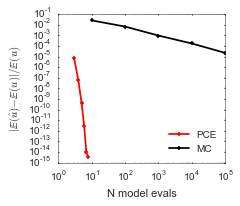

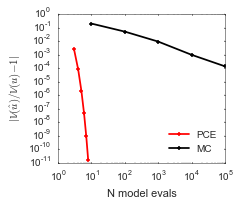

In [23]:
output_name_label = 'u'

fig = plt.figure(figsize=[3.5,3])
ax = fig.add_subplot(111)
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_ylim([1e-6,1e0])
ax.plot(Npc,Error_E,'.-r',label='PCE')
ax.plot(Nmc,Error_E_mc,'.-k',label='MC')
ax.set_xlabel('N model evals')
ax.set_ylabel(r'$|\mathbb{E}(\hat{'+output_name_label+'})-\mathbb{E}('+output_name_label+')|/\mathbb{E}('+output_name_label+')$')
ax.legend(loc='best')
fig.tight_layout()
fig.savefig('Figures/1_Convergence_E_'+output_name_label+'.pdf')


fig = plt.figure(figsize=[3.5,3])
ax = fig.add_subplot(111)
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_ylim([1e-4,1e0])
ax.plot(Npc,Error_Std,'.-r',label='PCE')
ax.plot(Nmc,Error_Std_mc,'.-k',label='MC')
ax.set_xlabel('N model evals')
ax.set_ylabel(r'$|\mathbb{V}(\hat{'+output_name_label+'})/\mathbb{V}('+output_name_label+') -1|$')
ax.legend(loc='best')
fig.tight_layout()
fig.savefig('Figures/1_Convergence_V_'+output_name_label+'.pdf')